In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
from datetime import datetime
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os
import glob
from PIL import Image
from scipy import stats
from straxen import units
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

Start import
Working on midway2-0411.rcc.local with the following versions 
and installation paths:
strax
	v0.15.1	/dali/lgrandi/strax/strax/strax
straxen
	v0.18.3	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
def mask_KrSingleS1(df):
    def line(x):
        return 0.55 * x + 15
    mask = (df['ds_s1_dt'] == 0)
    mask &= (df['s1_a_n_channels'] >= 90) & (df['s1_a_n_channels'] < 225)
    mask &= (line(df['s1_a_area']) > df['s1_a_n_channels'])
    mask &= (df['s1_a_range_50p_area'] >= 60) & (df['s1_a_range_50p_area'] < 1000)
    mask &= (df['s1_a_area_fraction_top'] < 0.68)
    return mask

In [4]:
def plot_area_width_aft_Kr(run_id, low = 0, high = 7, low2 = 0, high2 = 1, binning = 500,plot=False):
    events0 = st.get_df(run_id,'event_info_double',progress_bar=False)
    mask = mask_KrSingleS1(events0)
    livetime = (events0['time'][len(events0)-1]-events0['time'][0])/1e9
    events = events0[mask]
    ph_s1 = Histdd(events['s1_a_area'], events['s1_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_a_area'], events['s2_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_a_area'], events['s1_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_a_area'], events['s2_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    kr_rate = len(events)/livetime
    all_rate = len(events0)/livetime
    kr_rates, all_rates, slot_times = [], [], []
    for i in range(10):
        idx1, idx2 = int(i*(len(events0)-1)/10), int((i+1)*(len(events0)-1)/10)
        slot_time = (events0['time'][idx2]-events0['time'][idx1])/1e9
        trange = (events0['time']>events0['time'][idx1]) & (events0['time']<events0['time'][idx2])
        kr_rates = np.append(kr_rates,len(events0[mask & trange])/slot_time)
        all_rates = np.append(all_rates,len(events0[trange])/slot_time)
        timestamp = events0['time'][idx1]/1e9
        slot_times = np.append(slot_times,datetime.fromtimestamp(timestamp))
    if plot:
        plt.figure(figsize=(12,6))
        phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
        phcs2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("peak area (PE)", ha='right', x=1)
        plt.ylabel("area fraction top", ha='right', y=1)
        plt.title(f'run {run_id}')
        plt.xscale('log')
        plt.title(f'run {run_id} - Kr-rate: {kr_rate:.2f} Hz')
        plt.savefig(f'area_vs_aft_run{run_id}.png')
        """
        plt.figure(figsize=(12,6))
        ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
        ph_s2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("peak area (PE)", ha='right', x=1)
        plt.ylabel("peak width 50% (ns)", ha='right', y=1)
        plt.title(f'run {run_id} - Kr-rate: {kr_rate:.2f} Hz')
        plt.xscale('log')
        plt.yscale('log')
               
        plt.figure(figsize=(12,6))
        ph_s1s2 = Histdd(events['s1_a_area'], events['s2_a_area'],
                        bins=(np.logspace(0, 5, binning), np.logspace(1, 7, binning)))
        ph_s1s2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("S1 peak area (PE)", ha='right', x=1)
        plt.ylabel("S2 peak area (PE)", ha='right', y=1)
        plt.title(f'run {run_id} - Kr-rate: {kr_rate:.2f} Hz')
        plt.xscale('log')
        plt.yscale('log')
        """
    print(f'run {run_id}, livetime {livetime:.2f} s, Kr-rate: {kr_rate:.2f} Hz')
    return kr_rate, all_rate, kr_rates, all_rates, slot_times

run 018207, livetime 3600.75 s, Kr-rate: 18.82 Hz


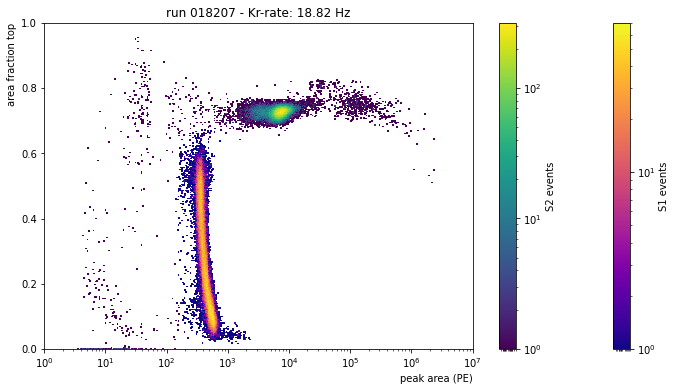

In [5]:
kr, aa, krs, ass, ss = plot_area_width_aft_Kr('018207',plot=1)

In [6]:
def plots_area_vs_aft(runs,gif=False):
    kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = [], [], [], [], []
    for i, run in enumerate(runs):
        kr_rate, all_rate, krs, alls, slots = plot_area_width_aft_Kr(run,plot=0)
        slot_times = np.append(slot_times,slots)
        kr_rates = np.append(kr_rates,krs)
        all_rates = np.append(all_rates,alls)
        tot_kr_rates = np.append(tot_kr_rates,kr_rate)
        tot_all_rates = np.append(tot_all_rates,all_rate)
    if gif:
        fp_in = f'area_vs_aft_run*.png'
        fp_out = f'area_vs_aft_run{runs[0]}-{runs[-1]}.gif'
        img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=500, loop=0)
        for i, run in enumerate(runs):
            os.remove(f'area_vs_aft_run{run}.png')
    return kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates

In [10]:
kr_runs = ['018159','018160','018161','018162'] # 03/05/2021
kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = plots_area_vs_aft(runs=kr_runs)

run 018159, livetime 576.92 s, Kr-rate: 10.67 Hz
run 018160, livetime 1554.37 s, Kr-rate: 13.01 Hz
run 018161, livetime 3602.65 s, Kr-rate: 16.56 Hz
run 018162, livetime 3602.29 s, Kr-rate: 19.29 Hz


In [12]:
def plot_kr_rate_vs_time(kr_rates,all_rates,slot_times):
    plt.figure(figsize=(12,6))
    dates = matplotlib.dates.date2num(slot_times + timedelta(hours=7))
    plt.plot_date(dates, kr_rates,'o',label='Kr-83m rate')
    plt.plot_date(dates, all_rates,'o',label='total rate')
    #plt.axvline(x = dates[22],color='black', linestyle = '--',label=f'valve at 0.2 turns')
    #plt.axvline(x = dates[52],color='m', linestyle = '--',label=f'valve at 0.4 turns')
    #plt.axvline(x = dates[83],color='b', linestyle = '--',label=f'valve at 0.8 turns')
    #plt.axvline(x = dates[130],color='r', linestyle = '--',label=f'valve at 3.2 turns')
    myFmt = matplotlib.dates.DateFormatter('%d %b %H:%M')
    plt.gca().xaxis.set_major_formatter(myFmt)
    plt.title(f'runs {kr_runs[0]} - {kr_runs[-1]}')
    plt.xlabel("LNGS time", ha='right', x=1,fontsize=12)
    plt.ylabel("Kr rate (Hz)", ha='right', y=1,fontsize=12)
    plt.legend(fontsize=14)

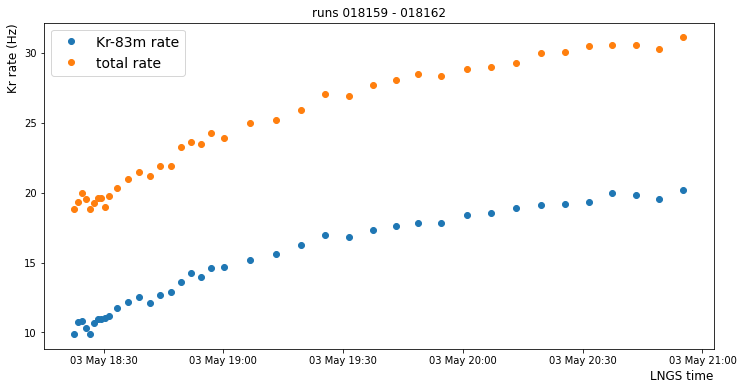

In [13]:
plot_kr_rate_vs_time(kr_rates,all_rates,slot_times)

run 018207, livetime 3600.75 s, Kr-rate: 18.82 Hz
run 018210, livetime 867.38 s, Kr-rate: 18.85 Hz
run 018212, livetime 3600.29 s, Kr-rate: 18.77 Hz
run 018215, livetime 1788.69 s, Kr-rate: 18.83 Hz
run 018219, livetime 1800.13 s, Kr-rate: 18.69 Hz
run 018221, livetime 1471.18 s, Kr-rate: 18.75 Hz
run 018223, livetime 1800.68 s, Kr-rate: 18.76 Hz
run 018225, livetime 1800.03 s, Kr-rate: 18.58 Hz
run 018227, livetime 1801.37 s, Kr-rate: 18.57 Hz
run 018229, livetime 1801.25 s, Kr-rate: 18.49 Hz
run 018231, livetime 1802.61 s, Kr-rate: 18.51 Hz
run 018233, livetime 1801.93 s, Kr-rate: 18.38 Hz
run 018235, livetime 1802.40 s, Kr-rate: 18.48 Hz
run 018237, livetime 1800.86 s, Kr-rate: 18.25 Hz
run 018239, livetime 1801.95 s, Kr-rate: 18.31 Hz
run 018241, livetime 1802.53 s, Kr-rate: 18.54 Hz
run 018243, livetime 1800.11 s, Kr-rate: 18.37 Hz
run 018245, livetime 1803.04 s, Kr-rate: 18.48 Hz
run 018247, livetime 1802.87 s, Kr-rate: 18.14 Hz
run 018249, livetime 1802.96 s, Kr-rate: 18.22 Hz


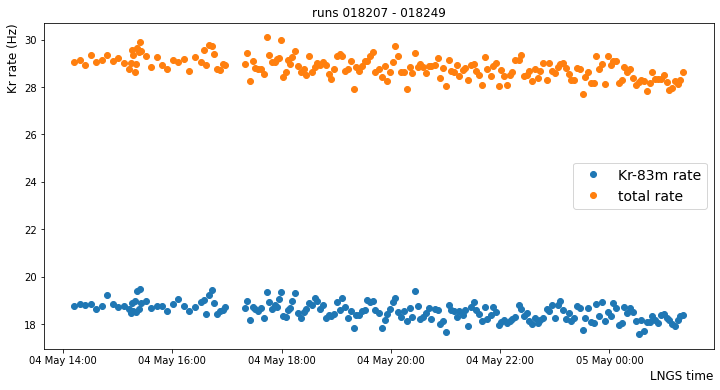

In [61]:
kr_runs = ['018207','018210','018212','018215','018219','018221','018223','018225',
           '018227','018229','018231','018233','018235','018237','018239','018241',
           '018243','018245','018247','018249']
kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = plots_area_vs_aft(runs=kr_runs)
plot_kr_rate_vs_time(kr_rates,all_rates,slot_times)

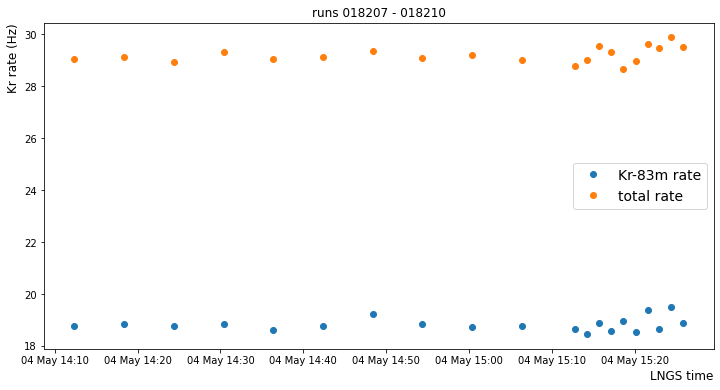

In [19]:
from datetime import datetime, timedelta
plt.figure(figsize=(12,6))
dates = matplotlib.dates.date2num(slot_times + timedelta(hours=7))
plt.plot_date(dates, kr_rates,'o',label='Kr-83m rate')
plt.plot_date(dates, all_rates,'o',label='total rate')
#plt.axvline(x = dates[22],color='black', linestyle = '--',label=f'valve at 0.2 turns')
#plt.axvline(x = dates[52],color='m', linestyle = '--',label=f'valve at 0.4 turns')
#plt.axvline(x = dates[83],color='b', linestyle = '--',label=f'valve at 0.8 turns')
#plt.axvline(x = dates[130],color='r', linestyle = '--',label=f'valve at 3.2 turns')
myFmt = matplotlib.dates.DateFormatter('%d %b %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title(f'runs {kr_runs[0]} - {kr_runs[-1]}')
plt.xlabel("LNGS time", ha='right', x=1,fontsize=12)
plt.ylabel("Kr rate (Hz)", ha='right', y=1,fontsize=12)
plt.legend(fontsize=14)